# Training a MACE model


In this notebook, the flow of training a MACE model is detailed step by step.



In [1]:
import matplotlib.pyplot    as plt
plt.ioff()
import numpy                as np
import torch
from time                   import time
import datetime             as dt
from tqdm                   import tqdm

from pathlib import Path
import sys

parentpath = str(Path().cwd())+'/'

print(parentpath)

sys.path.append(parentpath)

import src.mace.CSE_0D.dataset  as ds
import src.mace.train           as train
import src.mace.test            as test
import src.mace.load            as load
import src.mace.mace            as mace
from src.mace.loss              import Loss
import src.mace.loss            as loss
import src.mace.utils           as utils
from src.mace.input             import Input

specs_dict, idx_specs = utils.get_specs()

%reload_ext autoreload
%autoreload 2

/STER/silkem/MACE/


## Setting up

>***Note***:
>If you are training the architecture with your own data, you can set up the model in the following way. However, if you will follow the notebook, we will load a pre-trained model to continue the training, just for tutorial purposes. Then, skip the cells on "Set up the model".


### Naming the model
The default model to name the model is with the date and time of training. This can be adjusted with changing the parameter name.




In [2]:
now = dt.datetime.now()
name = str(now.strftime("%Y%m%d")+'_'+now.strftime("%H%M%S"))

path = parentpath + 'model/'+name

print(path)

/STER/silkem/MACE/model/20241025_125032


Make directories to store output and trained model.



In [3]:
utils.makeOutputDir(path)
utils.makeOutputDir(path+'/nn')

'/STER/silkem/MACE/model/20241025_125032/nn'

### Reading input file
Fill in the name of the input file for arg.

For tutorial purposes, the amount of training data and training epochs is limited in this example.

In [4]:
arg = 'example'

In [5]:
infile = parentpath+'input/'+arg+'.in'
input = Input(infile, name)
meta = input.make_meta(path)
input.print()

------------------------------
Name: 20241025_125032
------------------------------
     inputfile: /STER/silkem/MACE/input/example.in
      # hidden: 1
       ae type: simple
# z dimensions: 8
        scheme: int
  # evolutions: 16
     loss type: abs_idn
      # epochs: 15
 learning rate: 0.0001



### Set up Pytorch

In [6]:
cuda   = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1
kwargs = {'num_workers': 1, 'pin_memory': True}

### Set up the model


Make the model, randomly initialised.



In [7]:
model = mace.Solver(n_dim=input.n_dim, p_dim=4,z_dim = input.z_dim,
                    nb_hidden=input.nb_hidden, ae_type=input.ae_type,
                    scheme=input.scheme, nb_evol=input.nb_evol,
                    path = path,
                    DEVICE = DEVICE,
                    lr=input.lr )

num_params = utils.count_parameters(model)
print(f'\nThe model has {num_params} trainable parameters')


The model has 284692 trainable parameters


### Set up training & testing data

Load the train, validation, and test data sets.

In [8]:
traindata, testdata, data_loader, test_loader = ds.get_data(dt_fract=input.dt_fract,
                                                            nb_samples=input.nb_samples, batch_size=batch_size,
                                                            nb_test=input.nb_test,kwargs=kwargs, inpackage=True)

> Train state: True
Found paths: 13
number of test paths: 3
Selected test paths: 3
Selected paths: 7


> Train state: False
Found paths: 13
number of test paths: 3
Selected test paths: 3
Selected paths: 3


Dataset:
------------------------------
  total # of samples: 10
#   training samples: 7
# validation samples: 3
               ratio: 0.3
     #  test samples: 3


## Loading the pre-trained model


Setting the directory of the model.



In [9]:
outloc  = parentpath+'model/'
dirname = '20240604_160152'     ## analogue to int4 model of the paper

Loading the pre-trained model.



In [10]:
trained = load.Trained_MACE(outloc=outloc, dirname=dirname, epoch=5)
meta = trained.get_meta()
model = trained.model

model.path = path+'/'       ## Change the path of the model in order to keep the original model as it is
print(model.path)

The model has 284692 trainable parameters
/STER/silkem/MACE/model/20241025_125032/


## Training the model

Training the model in [Maes et al. (2024)](https://ui.adsabs.harvard.edu/abs/2024arXiv240503274M/abstract) happens it two stages:

1. For the first few epochs (input.ini_epochs) the models is trained with unscaled losses.
2. The losses of the model are rescaled, normalised based in the losses in the first few epochs.

### Stage 1
Initialise loss.

In [11]:
norm, fract = loss.initialise()

trainloss = Loss(norm, fract, input.losstype)
testloss  = Loss(norm, fract, input.losstype)

Train the model & time the training.

In [12]:
plt.ioff()

tic = time()
train.train(model,
            data_loader, test_loader,
            end_epochs = input.ini_epochs,
            trainloss=trainloss, testloss=testloss)
toc = time()
train_time1 = toc-tic

plt.close()


Integrated training scheme in use.

>>> Training model...
Epoch 1 complete! 	Average training loss:  0.00432 	Average validation loss:  0.0015
              time [secs]:  39.77
Epoch 2 complete! 	Average training loss:  0.00386 	Average validation loss:  0.00127
              time [secs]:  42.3
Epoch 3 complete! 	Average training loss:  0.0028 	Average validation loss:  0.00117
              time [secs]:  45.27
Epoch 4 complete! 	Average training loss:  0.00273 	Average validation loss:  0.00119
              time [secs]:  48.37
Epoch 5 complete! 	Average training loss:  0.00242 	Average validation loss:  0.00127
              time [secs]:  51.4

 	DONE!


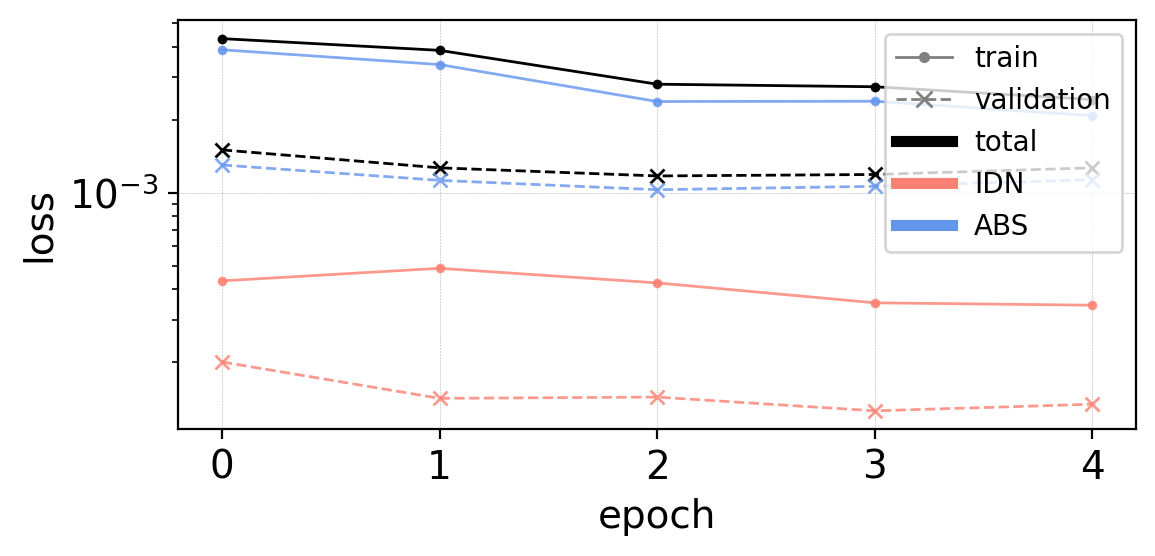

In [13]:
lossfig = loss.plot(trainloss, testloss, ylim = False, log = True, show = True)

### Stage 2
Normalise losses based on the past losses, and (optional) scale losses, given by parameter fract.

In [14]:
fract = input.get_facts()
trainloss.change_fract(fract)
testloss.change_fract(fract)

new_norm = trainloss.normalise()
testloss.change_norm(new_norm)

Continue the training.



In [15]:
plt.ioff()

tic = time()
train.train(model,
            data_loader, test_loader,
            start_epochs = input.ini_epochs, end_epochs = input.nb_epochs,
            trainloss=trainloss, testloss=testloss)
toc = time()
train_time2 = toc-tic

train_time = train_time1 + train_time2

plt.close()


Integrated training scheme in use.

>>> Training model...


Epoch 6 complete! 	Average training loss:  1.80448 	Average validation loss:  0.83203
              time [mins]:  1.1
Epoch 7 complete! 	Average training loss:  1.91832 	Average validation loss:  0.7724
              time [mins]:  1.14
Epoch 8 complete! 	Average training loss:  1.74071 	Average validation loss:  0.58716
              time [mins]:  1.19
Epoch 9 complete! 	Average training loss:  1.41528 	Average validation loss:  0.6713
              time [mins]:  1.24
Epoch 10 complete! 	Average training loss:  1.46788 	Average validation loss:  0.59928
              time [mins]:  1.29
Epoch 11 complete! 	Average training loss:  1.29752 	Average validation loss:  0.73441
              time [mins]:  1.34
Epoch 12 complete! 	Average training loss:  1.4966 	Average validation loss:  0.74751
              time [mins]:  1.39
Epoch 13 complete! 	Average training loss:  1.47651 	Average validation loss:  0.63229
              time [mins]:  1.44
Epoch 14 complete! 	Average training loss:  1.06

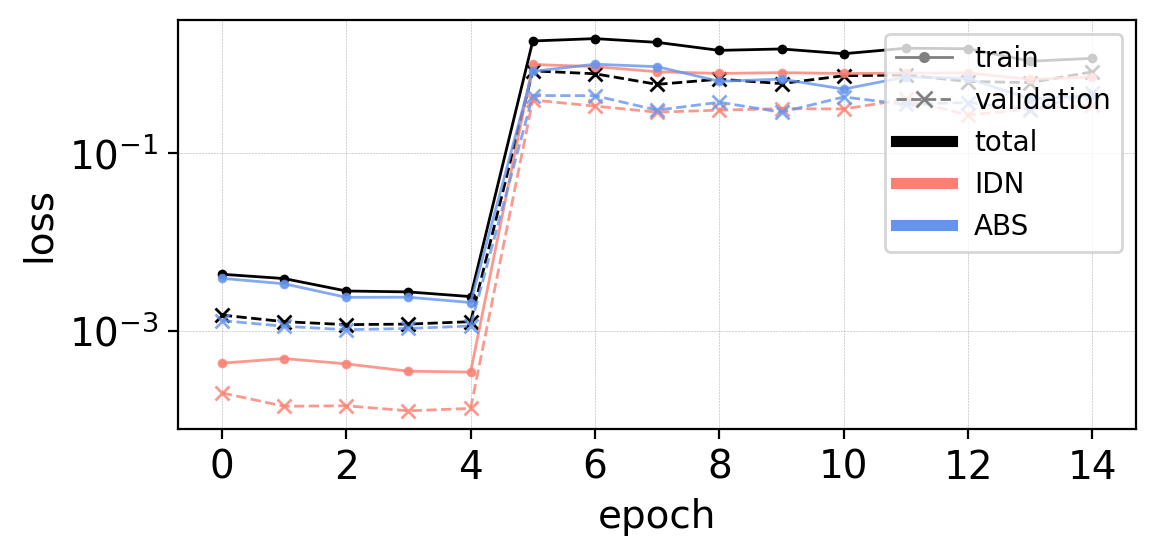

In [16]:
lossfig = loss.plot(trainloss, testloss, ylim = False, log = True, show = True)

## Saving the model
Save the losses & specifics of the data set.

In [17]:
print('path:', path)

trainloss.save(path+'/train')
testloss.save(path+'/valid')

min_max = np.stack((traindata.mins, traindata.maxs), axis=1)
np.save(path+'/minmax', min_max)

path: /STER/silkem/MACE/model/20241025_125032


Save the model and the status of the solver (see [torchode status](https://github.com/martenlienen/torchode/blob/main/torchode/status_codes.py) for more details).

In [19]:
torch.save(model.state_dict(),path+'/nn/nn.pt')

np.save(path+'/train/status', model.get_status('train')) # type: ignore
np.save(path +'/valid/status', model.get_status('test') ) # type: ignore

Plot the evolution of the loss and save the figure.



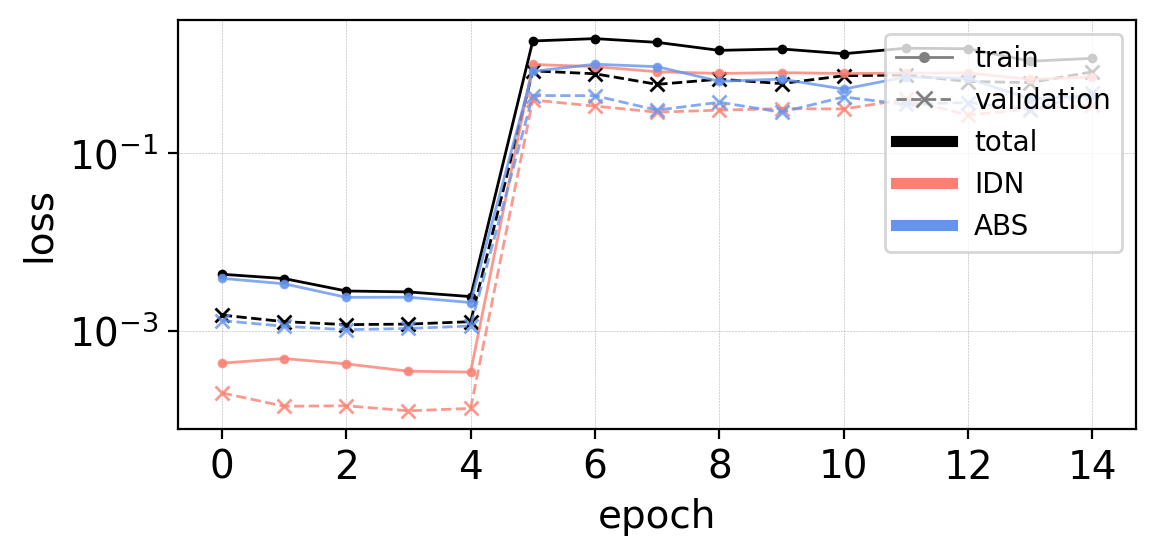

In [20]:
plt.close()
fig_loss = loss.plot(trainloss, testloss, len = input.nb_epochs)
plt.savefig(path+'/loss.png')
plt.show()

## Testing the model


Perform tests on the trained model to get an accuracy indication, according to the following error metric:

$$ {\rm error} = \frac{\log_{10}\boldsymbol{n}-\log_{10}\hat{\boldsymbol{n}}}{\log_{10}\boldsymbol{n}}, $$

which is executed element-wise and subsequently summed over the different chemical species

### Performing the tests

In [21]:
sum_err_step = 0
sum_err_evol = 0

step_calctime = list()
evol_calctime = list()

for i in tqdm(range(len(traindata.testpath))):
#     print(i+1,end='\r')
    testpath = traindata.testpath[i]

    err_test, err_evol, step_time, evol_time = test.test_model(model,testpath, meta, printing = False, inpackage=True, datapath='train' )

    sum_err_step += err_test
    sum_err_evol += err_evol

    step_calctime.append(step_time)
    evol_calctime.append(evol_time)

  0%|          | 0/3 [00:00<?, ?it/s]

> Train state: False
Found paths: 13
number of test paths: 3
Selected test paths: 3
Selected paths: 3


-------------------
Input of test model
-------------------
Mdot [Msol/yr]:       2e-08
v [km/s]:             10.0
Density proxi Mdot/v: 2e-14

Temp at 1e16 cm [K]:  12.19
Tstar:                2400.0
eps:                  0.85
-------------------



 33%|███▎      | 1/3 [00:00<00:01,  1.52it/s]

> Train state: False
Found paths: 13
number of test paths: 3
Selected test paths: 3
Selected paths: 3


-------------------
Input of test model
-------------------
Mdot [Msol/yr]:       1e-07
v [km/s]:             15.0
Density proxi Mdot/v: 6.666666666666667e-14

Temp at 1e16 cm [K]:  34.2
Tstar:                2650.0
eps:                  0.7
-------------------



 67%|██████▋   | 2/3 [00:01<00:00,  1.50it/s]

> Train state: False
Found paths: 13
number of test paths: 3
Selected test paths: 3
Selected paths: 3


-------------------
Input of test model
-------------------
Mdot [Msol/yr]:       1e-07
v [km/s]:             7.5
Density proxi Mdot/v: 1.3333333333333334e-13

Temp at 1e16 cm [K]:  34.84
Tstar:                2700.0
eps:                  0.7
-------------------



100%|██████████| 3/3 [00:01<00:00,  1.50it/s]


### Saving the outcome of the tests
The error saved is normalised over the amount of tests, given by len(traindata.testpath.

In [21]:
utils.makeOutputDir(path+'/test')

np.save(path+ '/test/sum_err_step.npy', np.array(sum_err_step/len(traindata.testpath)))
np.save(path+ '/test/sum_err_evol.npy', np.array(sum_err_evol/len(traindata.testpath)))

np.save(path+ '/test/calctime_evol.npy', evol_calctime)
np.save(path+ '/test/calctime_step.npy', step_calctime)

print('\nAverage error:')
print('           Step:', np.round(sum_err_step,3))
print('      Evolution:', np.round(sum_err_evol,3))


Average error:
           Step: 14.932
      Evolution: 31.391
